<a href="https://colab.research.google.com/github/adnacicko/StudyBuddy/blob/main/Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dependencies and imports for PDF processing and NLP analysis**

In [ ]:
!pip install PyPDF2 nltk pdfplumber spacy language-tool-python keybert
!python -m spacy download en_core_web_sm
!pip install transformers torch sentence-transformers

import pdfplumber
import spacy
import re
from collections import Counter
import nltk
from keybert import KeyBERT
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
import matplotlib.pyplot as plt
import numpy as np
import language_tool_python

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

nlp = spacy.load("en_core_web_sm")
kw_model = KeyBERT()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Text extraction function**

In [ ]:
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            print(f"Number of pages: {len(pdf.pages)}")
            for i, page in enumerate(pdf.pages, 1):
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
                print(f"Extracted page {i}: {len(page_text)} characters")
    except Exception as e:
        print(f"Error reading PDF: {e}")
    return text

**Text cleaning functions**

In [ ]:

def clean_for_spacy(text):
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'\t+', ' ', text)
    text = re.sub(r'[•\-·●▪➢○■►§→]', ' ', text)
    return text.strip()

def clean_sentence(sentence):
    words = sentence.split()
    cleaned_words = []
    prev_word = None
    for word in words:
        if word.lower() != prev_word:
            cleaned_words.append(word)
        prev_word = word.lower()
    sentence = ' '.join(cleaned_words)

    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = re.sub(r'\.([a-zA-Z])', r'. \1', sentence)
    sentence = sentence.strip()

    if sentence and sentence[0].islower():
        sentence = sentence[0].upper() + sentence[1:]

    if sentence and not sentence[-1] in '.!?':
        sentence += '.'

    return sentence

**Sentence filtering functions**

In [ ]:
def is_heading_or_fragment(sentence):
    words = sentence.split()
    sentence_lower = sentence.lower()

    if len(words) <= 5:
        return True

    if sentence.strip().endswith(':'):
        return True

    if re.match(r'^\d+\.?\s', sentence):
        return True

    heading_patterns = ['key idea', 'key difference', 'benefits:', 'solutions:',
                       'example:', 'note:', 'important:', 'remember:']
    if any(sentence_lower.startswith(pattern) for pattern in heading_patterns):
        if len(words) <= 8:
            return True

    if sentence_lower.startswith(('image', 'figure', 'fig.', 'table', 'chart')):
        return True

    return False

def is_meaningful_sentence(sentence):
    words = sentence.split()

    if len(words) < 8 or len(words) > 40:
        return False

    if not sentence.strip().endswith(('.', '!')):
        return False

    if sentence.strip().endswith('?'):
        return False

    content_words = [w for w in words if len(w) > 2]
    if len(content_words) < 5:
        return False

    doc = nlp(sentence)
    has_verb = any(token.pos_ == 'VERB' for token in doc)
    if not has_verb:
        return False

    sentence_lower = sentence.lower()
    excluded_patterns = [
        'example', 'ex.', 'e.g.', 'for instance',
        'result', 'results', 'conclusion', 'in conclusion',
        'vs', 'vs.', 'versus', 'compared to',
        'figure', 'fig.', 'table', 'chart',
        'reference', 'see', 'refer to',
        'introduction', 'summary', 'overview',
        'following', 'above', 'below',
        'chapter', 'section', 'page',
        'image', 'diagram'
    ]

    for pattern in excluded_patterns:
        if pattern in sentence_lower:
            return False

    cap_words = [w for w in words if w[0].isupper() and len(w) > 1]
    if len(cap_words) > len(words) * 0.5:
        return False

    has_subject = any(token.dep_ in ['nsubj', 'nsubjpass'] for token in doc)
    if not has_subject:
        return False

    return True

**Concept extraction**

In [ ]:
def extract_main_concept(sentence):
    doc = nlp(sentence)

    for token in doc:
        if token.dep_ in ['nsubj', 'nsubjpass']:
            concept = get_full_noun_phrase(token)
            if concept and is_valid_concept(concept):
                return concept, 'grammatical_subject'

    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'PRODUCT', 'GPE', 'EVENT', 'WORK_OF_ART', 'LAW', 'NORP']:
            if is_valid_concept(ent.text):
                return ent.text, 'named_entity'

    best_chunk = None
    max_score = 0

    for chunk in doc.noun_chunks:
        concept = chunk.text.strip()

        if not is_valid_concept(concept):
            continue

        score = 0
        position_score = 1.0 - (chunk.start / len(doc))
        score += position_score * 0.3

        if chunk.root.pos_ == 'PROPN':
            score += 0.4

        if len(concept.split()) >= 2:
            score += 0.3

        if score > max_score:
            max_score = score
            best_chunk = concept

    if best_chunk and max_score > 0.2:
        return best_chunk, 'noun_chunk'

    return None, None

def get_full_noun_phrase(token):
    phrase_tokens = []
    for t in token.subtree:
        if t.dep_ not in ['det', 'aux', 'auxpass']:
            phrase_tokens.append(t)

    phrase_tokens.sort(key=lambda t: t.i)
    phrase = ' '.join([t.text for t in phrase_tokens])
    phrase = phrase.strip()

    phrase = phrase.rstrip(',').rstrip(':').lstrip(',')
    phrase = re.sub(r'\s*\(\s*[A-Z]+\s*\)\s*$', '', phrase)
    phrase = re.sub(r'\s+', ' ', phrase)

    return phrase.strip()

def is_valid_concept(concept):
    concept_lower = concept.lower().strip()

    if len(concept_lower) < 3:
        return False

    concept_no_articles = re.sub(r'^(the|a|an)\s+', '', concept_lower)
    if len(concept_no_articles.split()) < 1:
        return False

    generic_words = {
        'it', 'this', 'that', 'these', 'those', 'you', 'we', 'they', 'he', 'she',
        'thing', 'things', 'way', 'ways', 'one', 'ones', 'some', 'many', 'all',
        'goal', 'model', 'system', 'data', 'idea', 'concept', 'method', 'approach',
        'result', 'process', 'part', 'use', 'type', 'form', 'kind', 'case',
        'agent', 'message', 'students', 'student', 'people', 'person'
    }

    if concept_lower in generic_words:
        return False

    article_generic_pattern = r'^(the|a|an)\s+(goal|model|system|data|concept|dataset|concepts|models)$'
    if re.match(article_generic_pattern, concept_lower):
        return False

    if re.match(r'^(these|those|this|that)\s+\w+$', concept_lower):
        return False

    verb_words = ['converts', 'detects', 'analyzes', 'makes', 'provides',
                  'uses', 'helps', 'creates', 'builds', 'generates', 'learns',
                  'neural', 'benefits']
    if concept_lower in verb_words:
        return False

    words = concept_lower.split()
    if len(words) >= 2:
        doc_last = nlp(words[-1])
        if len(doc_last) > 0 and doc_last[0].pos_ == 'VERB':
            return False

    if concept_lower.endswith((':',  ',', ';')) or concept_lower.startswith((',', ';')):
        return False

    doc = nlp(concept)
    if len(doc) > 0:
        verb_count = sum(1 for t in doc if t.pos_ == 'VERB')
        if verb_count / len(doc) > 0.5:
            return False

    has_noun = any(t.pos_ in ['NOUN', 'PROPN'] for t in doc)
    if not has_noun:
        return False

    if len(concept.split()) > 8:
        return False

    if len(concept.split()) == 1:
        if doc[0].pos_ != 'PROPN':
            if not concept_lower in ['classification', 'regression', 'clustering',
                                     'overfitting', 'underfitting', 'hyperparameters']:
                return False

    return True

**Question generation**

In [ ]:
def generate_question(sentence, concept):
    doc = nlp(sentence.lower())

    has_definition = is_definition_pattern(doc)
    has_causation = is_causation_pattern(doc)
    has_process = is_process_pattern(doc)
    has_purpose = is_purpose_pattern(doc)
    has_comparison = is_comparison_pattern(doc)

    if has_definition:
        return f"What is {concept}?"
    elif has_causation:
        return f"Why is {concept} important?"
    elif has_process:
        return f"How does {concept} work?"
    elif has_purpose:
        return f"What is {concept} used for?"
    elif has_comparison:
        return f"How does {concept} differ from alternatives?"
    else:
        return f"What is {concept}?"

def is_definition_pattern(doc):
    definition_verbs = {'be', 'mean', 'refer', 'define', 'represent', 'constitute'}
    return any(token.lemma_ in definition_verbs for token in doc if token.pos_ in ['VERB', 'AUX'])

def is_causation_pattern(doc):
    causation_words = {'because', 'since', 'why', 'reason', 'due', 'cause'}
    return any(token.lemma_ in causation_words for token in doc)

def is_process_pattern(doc):
    process_verbs = {'work', 'operate', 'function', 'process', 'perform'}
    return any(token.lemma_ in process_verbs for token in doc if token.pos_ == 'VERB')

def is_purpose_pattern(doc):
    purpose_words = {'use', 'utilize', 'employ', 'apply', 'serve', 'purpose', 'goal'}
    return any(token.lemma_ in purpose_words for token in doc)

def is_comparison_pattern(doc):
    comparison_words = {'differ', 'unlike', 'contrast', 'compare', 'versus', 'alternative'}
    return any(token.lemma_ in comparison_words for token in doc)

**Answer extraction**

In [ ]:
def extract_answer(sentence, concept, question):
    doc = nlp(sentence)

    if "What is" in question:
        answer = extract_definition_answer(doc, concept)
        if answer:
            return answer

    elif "How does" in question:
        answer = extract_process_answer(doc, concept)
        if answer:
            return answer

    elif "used for" in question:
        answer = extract_purpose_answer(doc, concept)
        if answer:
            return answer

    answer = extract_main_clause(doc, concept)
    return answer

def extract_definition_answer(doc, concept):
    for token in doc:
        if token.lemma_ == 'be' and token.pos_ in ['AUX', 'VERB']:
            start_idx = token.idx + len(token.text)
            answer = doc.text[start_idx:].strip()
            answer = clean_answer(answer, concept)

            if is_valid_answer(answer):
                return answer

    return None

def extract_process_answer(doc, concept):
    concept_lower = concept.lower()

    concept_found = False
    for token in doc:
        if concept_lower in token.text.lower():
            concept_found = True
            continue

        if concept_found and token.pos_ == 'VERB':
            verb_phrase = ' '.join([t.text for t in token.subtree])
            answer = clean_answer(verb_phrase, concept)
            if is_valid_answer(answer):
                return answer

    return None

def extract_purpose_answer(doc, concept):
    for i, token in enumerate(doc):
        if token.lemma_ in ['to', 'for'] and token.pos_ in ['PART', 'ADP']:
            answer = ' '.join([t.text for t in doc[i+1:]])
            answer = clean_answer(answer, concept)
            if is_valid_answer(answer):
                return answer

    return None

def extract_main_clause(doc, concept):
    sentence_text = doc.text

    parts = re.split(r'[,;—]', sentence_text)

    best_part = ""
    max_length = 0

    for part in parts:
        part = part.strip()
        if len(part.split()) > max_length and len(part.split()) >= 4:
            max_length = len(part.split())
            best_part = part

    answer = clean_answer(best_part if best_part else sentence_text, concept)
    return answer

def clean_answer(answer, concept):
    answer = re.sub(r'\b' + re.escape(concept) + r'\b', '', answer, flags=re.IGNORECASE)

    answer = re.sub(r'^[^\w]+', '', answer)
    answer = re.sub(r'[.!?]+$', '', answer)
    answer = re.sub(r'\s+', ' ', answer)
    answer = answer.strip()

    answer = re.sub(r'^(and|or|but)\s+', '', answer, flags=re.IGNORECASE)

    words = answer.split()
    if len(words) > 30:
        answer = ' '.join(words[:30])

    if answer and answer[0].islower():
        answer = answer[0].upper() + answer[1:] if len(answer) > 1 else answer.upper()

    return answer.strip()

def is_valid_answer(answer):
    if not answer:
        return False

    words = answer.split()

    if len(words) < 4:
        return False

    if len(words) > 35:
        return False

    doc = nlp(answer)
    has_verb = any(token.pos_ == 'VERB' for token in doc)
    has_noun = any(token.pos_ in ['NOUN', 'PROPN'] for token in doc)

    if not has_verb and not has_noun:
        return False

    if answer.lower().startswith(('and ', 'or ', 'but ', 'yet ')):
        return False

    return True

**Quality filtering**

In [ ]:
def is_quality_qa_pair(qa_pair):
    concept = qa_pair['concept']
    question = qa_pair['question']
    answer = qa_pair['answer']

    if not is_valid_concept(concept):
        return False

    if not is_valid_answer(answer):
        return False

    if answer.lower().strip() == concept.lower().strip():
        return False

    q_words = set(question.lower().split())
    a_words = set(answer.lower().split())
    overlap = len(q_words & a_words) / len(a_words) if len(a_words) > 0 else 0
    if overlap > 0.7:
        return False

    return True

**Main QA generation pipeline**

In [ ]:
def generate_qa_pairs(sentences):
    qa_pairs = []
    seen_concepts = set()

    for i, sentence in enumerate(sentences):
        print(f"\nProcessing sentence {i+1}/{len(sentences)}: {sentence[:70]}...")

        concept, method = extract_main_concept(sentence)

        if not concept:
            print(f"  ❌ No suitable concept found")
            continue

        concept_normalized = concept.lower().strip()
        if concept_normalized in seen_concepts:
            print(f"Duplicate concept: '{concept}' - skipping")
            continue

        print(f"Concept: '{concept}' (method: {method})")

        question = generate_question(sentence, concept)

        answer = extract_answer(sentence, concept, question)

        qa_pair = {
            'sentence': sentence,
            'concept': concept,
            'question': question,
            'answer': answer,
            'method': method
        }

        if is_quality_qa_pair(qa_pair):
            qa_pairs.append(qa_pair)
            seen_concepts.add(concept_normalized)
            print(f"  Q: {question}")
            print(f"  A: {answer}")
        else:
            print(f"Low quality, skipped")

    return qa_pairs

**Main execution**

In [ ]:
print("STUDY BUDDY QUESTION GENERATION SYSTEM")
pdf_path = "/content/Introduction.pdf"

print("\n[1] Extracting text from PDF...")
raw_text = extract_text_from_pdf(pdf_path)

print("\n[2] Cleaning text...")
clean_text = clean_for_spacy(raw_text)

print("\n[3] Segmenting sentences...")
doc = nlp(clean_text)
raw_sentences = [sent.text.strip() for sent in doc.sents]
print(f"   Found {len(raw_sentences)} sentences")


print("\n[4] Removing headings and cleaning...")
cleaned_sentences = []
for sent in raw_sentences:
    sent = clean_sentence(sent)
    if not is_heading_or_fragment(sent):
        cleaned_sentences.append(sent)
print(f"   Kept {len(cleaned_sentences)} non-heading sentences")

print("\n[5] Filtering meaningful sentences...")
meaningful_sentences = [sent for sent in cleaned_sentences if is_meaningful_sentence(sent)]
print(f"   Kept {len(meaningful_sentences)} meaningful sentences")
for i, sent in enumerate(meaningful_sentences, 1):
    print(f"{i}. {sent}")

final_sentences = meaningful_sentences

print("\n[6] Generating QA pairs...")
nlp_qa_pairs = generate_qa_pairs(final_sentences)

print("\nQA GENERATION RESULTS")
print(f"\nGenerated {len(nlp_qa_pairs)} QA pairs from {len(final_sentences)} sentences")
if len(final_sentences) > 0:
    print(f"Coverage: {(len(nlp_qa_pairs)/len(final_sentences)*100):.1f}%\n")

print("\nALL QA PAIRS")
for i, qa in enumerate(nlp_qa_pairs, 1):
    print(f"\n{i}. Q: {qa['question']}")
    print(f"   A: {qa['answer']}")
    print(f"   Concept: {qa['concept']} [{qa['method']}]")
    print(f"   Source: {qa['sentence'][:100]}...")


STUDY BUDDY QUESTION GENERATION SYSTEM

[1] Extracting text from PDF...
Number of pages: 18
Extracted page 1: 0 characters
Extracted page 2: 911 characters
Extracted page 3: 1564 characters
Extracted page 4: 1811 characters
Extracted page 5: 775 characters
Extracted page 6: 1666 characters
Extracted page 7: 2057 characters
Extracted page 8: 1944 characters
Extracted page 9: 2956 characters
Extracted page 10: 1848 characters
Extracted page 11: 1049 characters
Extracted page 12: 1456 characters
Extracted page 13: 583 characters
Extracted page 14: 1562 characters
Extracted page 15: 1176 characters
Extracted page 16: 1379 characters
Extracted page 17: 895 characters
Extracted page 18: 822 characters

[2] Cleaning text...

[3] Segmenting sentences...
   Found 244 sentences

[4] Removing headings and cleaning...
   Kept 177 non-heading sentences

[5] Filtering meaningful sentences...
   Kept 95 meaningful sentences
1. Project Planning The IT project performance model defines the Project Plan

**Sentence length analysis**


SENTENCE LENGTH ANALYSIS

Total sentences: 95
Average length: 121.0 characters
Longest: 254 characters
Shortest: 44 characters

TOP 5 LONGEST SENTENCES:

1. Length: 254 characters, 38 words
----------------------------------------
Although the planning phase had been extensive and included cutting edge technologies and ambitious goals, the execution phase failed to adapt the plans effectively to real world complexities, leading to significant operational and reputational setbacks.

2. Length: 216 characters, 36 words
----------------------------------------
The Planning Process phase includes any activity that contributes to the definition of project goals, mission, vision, business drivers and expected values, project requirements, execution plans, and potential risks.

3. Length: 201 characters, 30 words
----------------------------------------
Furthermore, communication between contractors and operational teams broke down during execution, leading to delayed responses to malfunctio

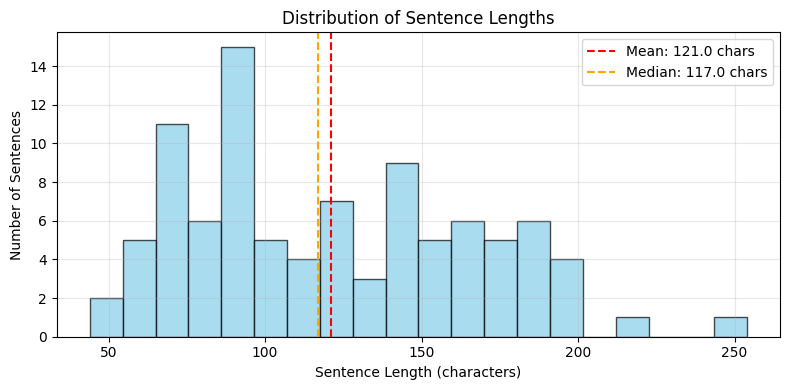

In [ ]:
print("\nSENTENCE LENGTH ANALYSIS")
sorted_sentences = sorted(final_sentences, key=lambda x: len(x), reverse=True)

print(f"\nTotal sentences: {len(final_sentences)}")
print(f"Average length: {sum(len(sent) for sent in final_sentences) / len(final_sentences):.1f} characters")
print(f"Longest: {len(sorted_sentences[0])} characters")
print(f"Shortest: {len(sorted_sentences[-1])} characters")

print("\nTOP 5 LONGEST SENTENCES:")

for i, sentence in enumerate(sorted_sentences[:5], 1):
    words = word_tokenize(sentence)
    word_count = len(words)
    print(f"\n{i}. Length: {len(sentence)} characters, {word_count} words")
    print("-" * 40)
    print(sentence)

sentence_lengths = [len(sent) for sent in final_sentences]

plt.figure(figsize=(8, 4))
plt.hist(sentence_lengths, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(sentence_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(sentence_lengths):.1f} chars')
plt.axvline(np.median(sentence_lengths), color='orange', linestyle='--', label=f'Median: {np.median(sentence_lengths):.1f} chars')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Word level analysis**


WORD-LEVEL ANALYSIS

Total words: 1993
Unique words: 776
Lexical diversity: 2.57
Average word length: 4.96 characters

Word Length Distribution:
  1 characters: 323 words (16.2%)
  2 characters: 202 words (10.1%)
  3 characters: 296 words (14.9%)
  4 characters: 197 words (9.9%)
  5 characters: 202 words (10.1%)
  6 characters: 121 words (6.1%)
  7 characters: 201 words (10.1%)
  8 characters: 157 words (7.9%)
  9 characters: 98 words (4.9%)
  10 characters: 65 words (3.3%)
  11 characters: 58 words (2.9%)
  12 characters: 45 words (2.3%)
  13 characters: 20 words (1.0%)
  14 characters: 6 words (0.3%)
  15 characters: 2 words (0.1%)

Top 10 Longest Unique Words:
  1. troubleshooting (15 characters)
  2. underestimation (15 characters)
  3. interconnected (14 characters)
  4. infrastructure (14 characters)
  5. Considerations (14 characters)
  6. underestimated (14 characters)
  7. questionnaires (14 characters)
  8. misunderstood (13 characters)
  9. theoretically (13 characters)
  1

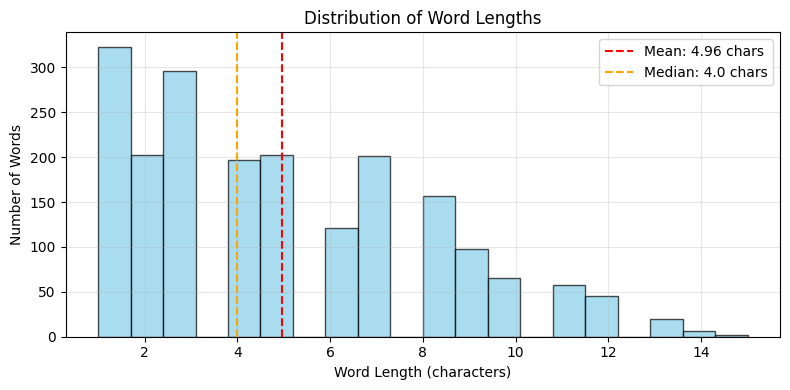

In [ ]:
print("\nWORD-LEVEL ANALYSIS")
filtered_text = ' '.join(final_sentences)
words = word_tokenize(filtered_text)
words = [word for word in words if word.strip()]

print(f"\nTotal words: {len(words)}")
print(f"Unique words: {len(set(words))}")
print(f"Lexical diversity: {len(words)/len(set(words)):.2f}")

total_characters = sum(len(word) for word in words)
average_word_length = total_characters / len(words)
print(f"Average word length: {average_word_length:.2f} characters")

print(f"\nWord Length Distribution:")
word_lengths = [len(word) for word in words]
max_length = max(word_lengths)
for length in range(1, max_length + 1):
    count = word_lengths.count(length)
    if count > 0:
        percentage = (count / len(words)) * 100
        print(f"  {length} characters: {count} words ({percentage:.1f}%)")

print(f"\nTop 10 Longest Unique Words:")
unique_words_sorted = sorted(set(words), key=lambda x: len(x), reverse=True)
for i, word in enumerate(unique_words_sorted[:10], 1):
    print(f"  {i}. {word} ({len(word)} characters)")

plt.figure(figsize=(8, 4))
plt.hist(word_lengths, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(word_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(word_lengths):.2f} chars')
plt.axvline(np.median(word_lengths), color='orange', linestyle='--', label=f'Median: {np.median(word_lengths):.1f} chars')
plt.xlabel('Word Length (characters)')
plt.ylabel('Number of Words')
plt.title('Distribution of Word Lengths')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Word frequency analysis**


WORD FREQUENCY ANALYSIS

Top 20 most common words:
  project: 42
  phase: 23
  planning: 17
  execution: 16
  requirements: 15
  system: 14
  needs: 12
  stakeholders: 8
  users: 8
  app: 8
  design: 8
  performance: 7
  development: 7
  quality: 7
  time: 7
  jad: 7
  process: 6
  data: 6
  ensure: 6
  risks: 5


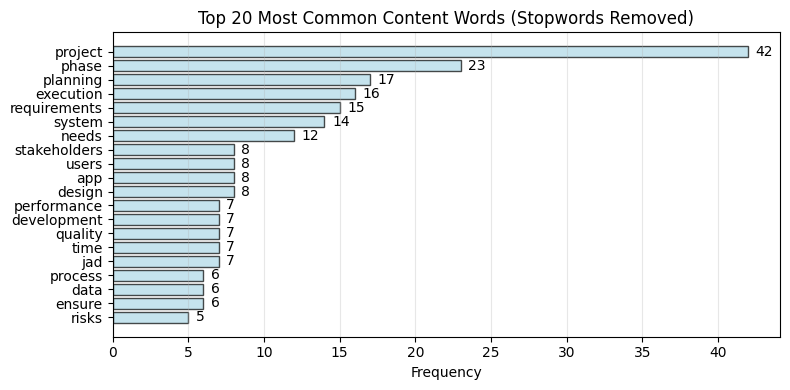

In [ ]:
print("\nWORD FREQUENCY ANALYSIS")
stop_words = set(stopwords.words('english'))
content_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
word_freq = FreqDist(content_words)

print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count}")

top_20_common = word_freq.most_common(20)
words_list, counts = zip(*top_20_common)

plt.figure(figsize=(8, 4))
bars = plt.barh(range(len(words_list)), counts, color='lightblue', alpha=0.7, edgecolor='black')
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Content Words (Stopwords Removed)')
plt.gca().invert_yaxis()

for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{count}', va='center', ha='left')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Bigram analysis**


BIGRAM ANALYSIS

Top 10 most common word pairs:
  execution phase: 8
  project execution: 7
  planning phase: 7
  jad session: 5
  project planning: 4
  phase project: 4
  project development: 3
  potential risks: 3
  outcomes project: 3
  joint application: 3


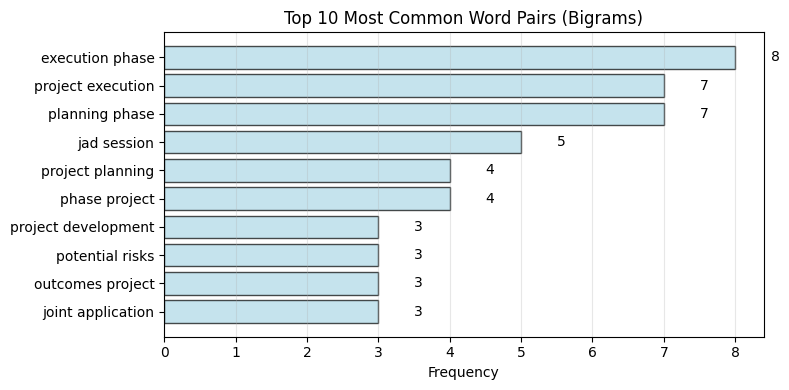

In [ ]:
print("\nBIGRAM ANALYSIS")
bigrams_list = list(bigrams(content_words))
bigram_freq = FreqDist(bigrams_list)

print(f"\nTop 10 most common word pairs:")
for (word1, word2), count in bigram_freq.most_common(10):
    print(f"  {word1} {word2}: {count}")

top_10_bigrams = bigram_freq.most_common(10)
bigram_pairs = [f"{word1} {word2}" for (word1, word2), count in top_10_bigrams]
counts_bigrams = [count for (word1, word2), count in top_10_bigrams]

plt.figure(figsize=(8, 4))
bars = plt.barh(range(len(bigram_pairs)), counts_bigrams, color='lightblue', alpha=0.7, edgecolor='black')
plt.yticks(range(len(bigram_pairs)), bigram_pairs)
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Word Pairs (Bigrams)')
plt.gca().invert_yaxis()

for i, (bar, count) in enumerate(zip(bars, counts_bigrams)):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{count}', va='center', ha='left')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**QA Pair Quality Analysis**


QA PAIR QUALITY ANALYSIS

COVERAGE METRICS:
   - Generated QA pairs: 85/95
   - Coverage rate: 89.5%

CONCEPT PRECISION:
   - Concept appears in question: 100.0%



GRAMMATICAL QUALITY:
   - Average grammatical score: 0.93/1.0


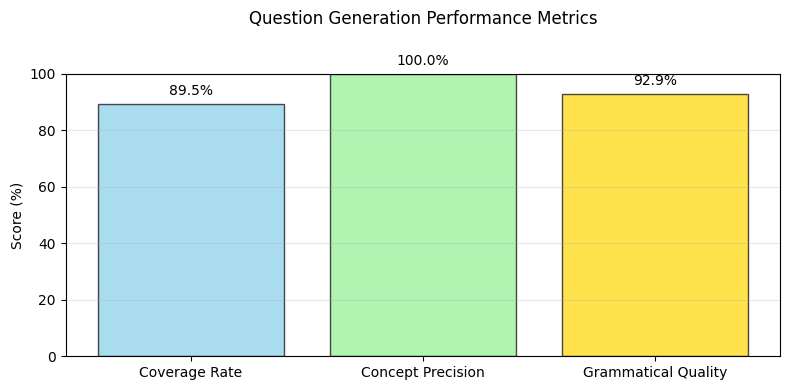

In [ ]:
print("\nQA PAIR QUALITY ANALYSIS")
total_input_sentences = len(final_sentences)
coverage_percentage = (len(nlp_qa_pairs) / total_input_sentences) * 100

print(f"\nCOVERAGE METRICS:")
print(f"   - Generated QA pairs: {len(nlp_qa_pairs)}/{total_input_sentences}")
print(f"   - Coverage rate: {coverage_percentage:.1f}%")

concept_in_question = 0

for qa in nlp_qa_pairs:
    concept = qa['concept'].lower()
    question = qa['question'].lower()
    if concept in question:
        concept_in_question += 1

concept_question_precision = (concept_in_question / len(nlp_qa_pairs)) * 100

print(f"\nCONCEPT PRECISION:")
print(f"   - Concept appears in question: {concept_question_precision:.1f}%")

try:
    tool = language_tool_python.LanguageTool('en-US')
    grammatical_scores = []

    for qa in nlp_qa_pairs:
        question = qa['question']
        matches = tool.check(question)
        error_count = len(matches)

        if error_count == 0:
            grammatical_scores.append(1.0)
        elif error_count <= 2:
            grammatical_scores.append(0.5)
        else:
            grammatical_scores.append(0.0)

    avg_grammaticality = sum(grammatical_scores) / len(grammatical_scores)
    print(f"\nGRAMMATICAL QUALITY:")
    print(f"   - Average grammatical score: {avg_grammaticality:.2f}/1.0")

except Exception as e:
    print(f"\nGRAMMATICAL QUALITY: Skipped (LanguageTool not available: {e})")
    avg_grammaticality = None

plt.figure(figsize=(8, 4))

metrics = ['Coverage Rate', 'Concept Precision']
scores = [coverage_percentage, concept_question_precision]

if avg_grammaticality is not None:
    metrics.append('Grammatical Quality')
    scores.append(avg_grammaticality * 100)

bars = plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'gold'][:len(metrics)], alpha=0.7, edgecolor='black')

plt.ylabel('Score (%)')
plt.title('Question Generation Performance Metrics\n\n')
plt.ylim(0, 100)

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{score:.1f}%', ha='center', va='bottom')

plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

**Question type distribution**


QUESTION TYPE DISTRIBUTION

Question Type Distribution:
   - What is: 79 (92.9%)
   - Why is: 4 (4.7%)
   - How does: 2 (2.4%)


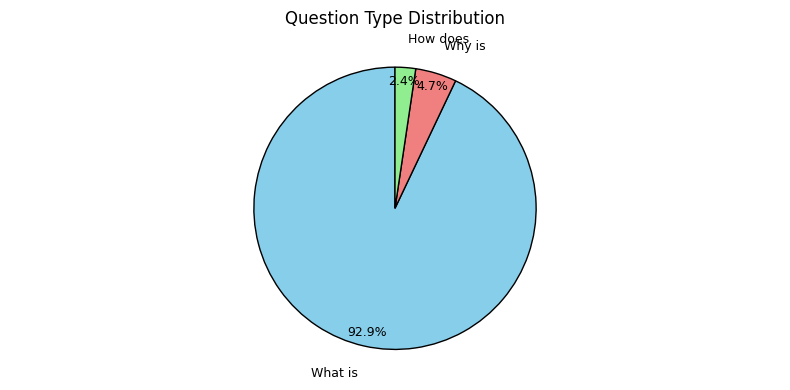

In [ ]:
print("\nQUESTION TYPE DISTRIBUTION")
question_types = []
question_patterns = {
    'What is': r'^What is',
    'How does': r'^How does',
    'What is.*used for': r'What is.*used for',
    'Why is': r'^Why is',
    'How does.*differ': r'How does.*differ'
}

for qa in nlp_qa_pairs:
    question = qa['question']
    matched = False
    for q_type, pattern in question_patterns.items():
        if re.search(pattern, question, re.IGNORECASE):
            question_types.append(q_type)
            matched = True
            break
    if not matched:
        question_types.append('Other')

type_distribution = Counter(question_types)

print(f"\nQuestion Type Distribution:")
for q_type, count in type_distribution.most_common():
    percentage = (count / len(nlp_qa_pairs)) * 100
    print(f"   - {q_type}: {count} ({percentage:.1f}%)")


plt.figure(figsize=(8, 4))
labels = list(type_distribution.keys())
sizes = list(type_distribution.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpurple', 'lightcyan'][:len(labels)],
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        textprops={'fontsize': 9},
        labeldistance=1.2,
        pctdistance=0.9)

plt.title('Question Type Distribution\n')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Answer length analysis**


ANSWER LENGTH ANALYSIS

Answer Length Statistics:
   - Average answer length: 11.1 words
   - Empty answers: 0
   - Answer length range: 5 to 28 words


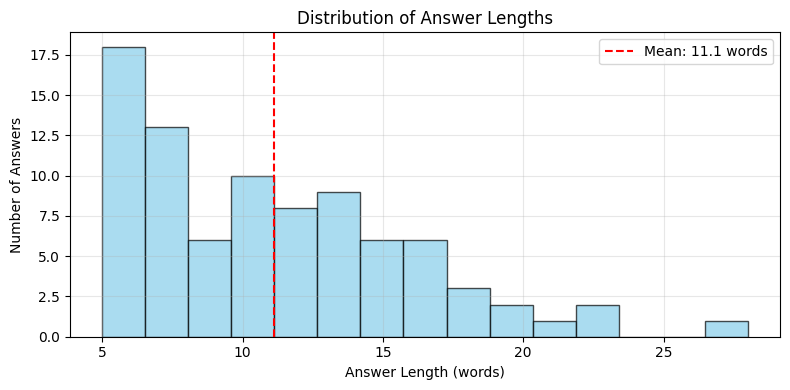

In [ ]:
print("\nANSWER LENGTH ANALYSIS")
answer_lengths = []
empty_answers = 0

for qa in nlp_qa_pairs:
    answer = qa['answer'].strip()
    if not answer or answer == '':
        empty_answers += 1
        answer_lengths.append(0)
    else:
        word_count = len(answer.split())
        answer_lengths.append(word_count)

avg_answer_length = sum(answer_lengths) / len(answer_lengths)

print(f"\nAnswer Length Statistics:")
print(f"   - Average answer length: {avg_answer_length:.1f} words")
print(f"   - Empty answers: {empty_answers}")
print(f"   - Answer length range: {min(answer_lengths)} to {max(answer_lengths)} words")

plt.figure(figsize=(8, 4))
plt.hist(answer_lengths, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(answer_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(answer_lengths):.1f} words')
plt.xlabel('Answer Length (words)')
plt.ylabel('Number of Answers')
plt.title('Distribution of Answer Lengths')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Failure analysis**

In [ ]:
print("\nFAILURE ANALYSIS")
problematic_pairs = []
for i, qa in enumerate(nlp_qa_pairs):
    answer_words = len(qa['answer'].split())
    if answer_words <= 2:
        problematic_pairs.append((i, qa, f"Short answer ({answer_words} words)"))
    elif qa['concept'].lower() not in qa['question'].lower():
        problematic_pairs.append((i, qa, "Concept missing from question"))

if problematic_pairs:
    print(f"\nFound {len(problematic_pairs)} potentially problematic QA pairs:")
    for idx, qa, issue in problematic_pairs[:5]:
        print(f"  #{idx+1}: {issue}")
        print(f"    Q: {qa['question']}")
        print(f"    A: {qa['answer']}")
else:
    print("\nNo major issues detected automatically")


FAILURE ANALYSIS

No major issues detected automatically


**Question vs. Answer Length**


QUESTION VS ANSWER LENGTH


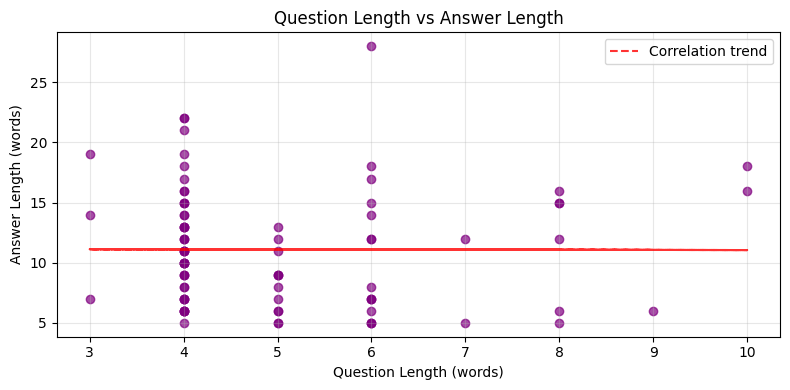

In [ ]:
print("\nQUESTION VS ANSWER LENGTH")
plt.figure(figsize=(8, 4))

question_lengths = [len(qa['question'].split()) for qa in nlp_qa_pairs]
answer_lengths_plot = [len(qa['answer'].split()) for qa in nlp_qa_pairs]

plt.scatter(question_lengths, answer_lengths_plot, alpha=0.7, color='purple')

z = np.polyfit(question_lengths, answer_lengths_plot, 1)
p = np.poly1d(z)
plt.plot(question_lengths, p(question_lengths), "r--", alpha=0.8, label='Correlation trend')

plt.xlabel('Question Length (words)')
plt.ylabel('Answer Length (words)')
plt.title('Question Length vs Answer Length')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**FINAL SUMMARY**

In [ ]:
print("\nANALYSIS COMPLETE")
print(f"\n✓ Processed {len(final_sentences)} sentences")
print(f"✓ Generated {len(nlp_qa_pairs)} QA pairs")
print(f"✓ Coverage rate: {coverage_percentage:.1f}%")
print(f"✓ Average answer length: {avg_answer_length:.1f} words")
print("\nAll analyses and visualizations complete!")


ANALYSIS COMPLETE

✓ Processed 95 sentences
✓ Generated 85 QA pairs
✓ Coverage rate: 89.5%
✓ Average answer length: 11.1 words

All analyses and visualizations complete!


**CHANGE 9: Compare With Simpler Approaches**

In [ ]:
def baseline_1_template_only(sentences):
    """
    Baseline 1: Simple template-based approach
    - Extract first noun phrase
    - Generate "What is X?" question
    - Use rest of sentence as answer
    """
    qa_pairs = []

    for sentence in sentences:
        doc = nlp(sentence)

        # Get first noun chunk
        noun_chunks = list(doc.noun_chunks)
        if not noun_chunks:
            continue

        concept = noun_chunks[0].text.strip()

        # Simple question generation
        question = f"What is {concept}?"

        # Answer = rest of sentence after first noun phrase
        concept_end = noun_chunks[0].end_char
        answer = sentence[concept_end:].strip()

        # Basic cleaning
        answer = answer.lstrip(',:;-').strip()
        if not answer:
            answer = "No answer extracted"

        qa_pairs.append({
            'sentence': sentence,
            'concept': concept,
            'question': question,
            'answer': answer,
            'method': 'template_only'
        })

    return qa_pairs

In [ ]:
def baseline_2_spacy_only(sentences):
    """
    Baseline 2: spaCy-only approach (no KeyBERT)
    - Use spaCy grammatical analysis
    - No semantic validation
    - Simple rule-based question generation
    """
    qa_pairs = []
    seen_concepts = set()

    for sentence in sentences:
        doc = nlp(sentence)

        # Extract concept using only spaCy
        concept = None
        method = None

        # Priority 1: Grammatical subject
        for token in doc:
            if token.dep_ in ['nsubj', 'nsubjpass']:
                concept = get_full_noun_phrase(token)
                method = 'grammatical_subject'
                break

        # Priority 2: Named entities
        if not concept:
            for ent in doc.ents:
                if ent.label_ in ['PERSON', 'ORG', 'PRODUCT', 'GPE']:
                    concept = ent.text
                    method = 'named_entity'
                    break

        # Priority 3: First noun chunk
        if not concept:
            noun_chunks = list(doc.noun_chunks)
            if noun_chunks:
                concept = noun_chunks[0].text
                method = 'noun_chunk'

        if not concept:
            continue

        # Skip duplicates
        concept_normalized = concept.lower().strip()
        if concept_normalized in seen_concepts:
            continue

        # Basic validation
        if not is_valid_concept(concept):
            continue

        # Generate question (same logic as hybrid)
        question = generate_question(sentence, concept)

        # Extract answer (same logic as hybrid)
        answer = extract_answer(sentence, concept, question)

        qa_pair = {
            'sentence': sentence,
            'concept': concept,
            'question': question,
            'answer': answer,
            'method': method
        }

        # Apply same quality filter
        if is_quality_qa_pair(qa_pair):
            qa_pairs.append(qa_pair)
            seen_concepts.add(concept_normalized)

    return qa_pairs

In [ ]:
print("\n[1] Running Baseline 1: Template Only...")
baseline1_qa = baseline_1_template_only(final_sentences)
print(f"   Generated {len(baseline1_qa)} QA pairs")

for i, qa in enumerate(baseline1_qa, 1):
    print(f"\n{i}. Q: {qa['question']}")
    print(f"   A: {qa['answer']}")
    print(f"   Concept: {qa['concept']}")
    print(f"   Source: {qa['sentence'][:80]}...")

print("\n[2] Running Baseline 2: spaCy Only...")
baseline2_qa = baseline_2_spacy_only(final_sentences)
print(f"   Generated {len(baseline2_qa)} QA pairs")

for i, qa in enumerate(baseline2_qa, 1):
    print(f"\n{i}. Q: {qa['question']}")
    print(f"   A: {qa['answer']}")
    print(f"   Concept: {qa['concept']} [{qa['method']}]")
    print(f"   Source: {qa['sentence'][:80]}...")


[1] Running Baseline 1: Template Only...
   Generated 95 QA pairs

1. Q: What is The IT project performance model?
   A: defines the Project Planning component as the first phase of the project development process.
   Concept: The IT project performance model
   Source: Project Planning The IT project performance model defines the Project Planning c...

2. Q: What is The Planning Process phase?
   A: includes any activity that contributes to the definition of project goals, mission, vision, business drivers and expected values, project requirements, execution plans, and potential risks.
   Concept: The Planning Process phase
   Source: The Planning Process phase includes any activity that contributes to the definit...

3. Q: What is other words?
   A: it prepares the project for Execution and Control phases, whose performance depends on the quality of the outcomes of the Planning phase.
   Concept: other words
   Source: In other words, it prepares the project for Execution and Contro